# MIA attacks on Length-of-Stay predictor, Logistic Regression
## Installation of Packages in Conda

To install the required packages in your conda environment, you can use the following commands:

```bash
conda install h5py
conda install pytables


In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.append(project_root)

from examples.mia.LOS.utils.data_processing import get_mimic_dataloaders, get_mimic_dataset
from examples.mia.LOS.utils.model_LR import LR, create_trained_model_and_metadata


## Train the classifier
For the LR, the data should be flatten. So set the value to True for the LR model anb False for the GRU-D

In [ ]:
# Generate the dataset and dataloaders
path = os.path.join(os.getcwd(), "data/")
use_LR = True # If True, use a logistic regression model. If False, use a GRUD model.
dataset, train_indices, validation_indices, test_indices, early_stop_indices = get_mimic_dataset(path, train_frac = 0.5,
                                                                            test_frac = 0.2,
                                                                            validation_frac = 0,
                                                                            early_stop_frac = 0,
                                                                            use_LR = use_LR)

In [ ]:
train_loader, validation_loader, test_loader, early_stop_loader = get_mimic_dataloaders(dataset,
                          train_indices,
                          validation_indices,
                          test_indices,
                          early_stop_indices,
                          batch_size=128)

In [8]:
n_features = dataset.x.shape[1]
print(f"Number of features: {n_features}")

model = LR(n_features)
train_acc, train_loss, test_acc, test_loss = create_trained_model_and_metadata(model,
                                                                               train_loader,
                                                                               test_loader,
                                                                               lr = 0.0001,
                                                                                weight_decay = 5.392,
                                                                               epochs=20)

Number of features: 7488


Training Progress: 100%|██████████| 20/20 [00:27<00:00,  1.37s/it]


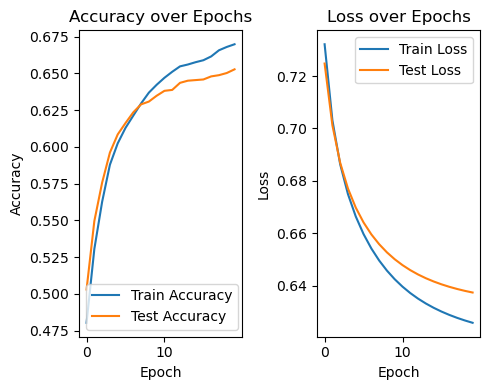

In [9]:
import matplotlib.pyplot as plt

# Plot training and test accuracy
plt.figure(figsize=(5, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label="Train Accuracy")
plt.plot(test_acc, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

# Plot training and test loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label="Train Loss")
plt.plot(test_loss, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

## Attack the LR model
Modify ```audit.yaml ``` file to attack LR model: 
  
  ```
  module_path: "utils/model_LR.py" 
  model_class: "LR"
  target_folder: "./target_LR"
  data_path: "./data/flattened/dataset.pkl"
  ```


In [10]:
from mimic_LR_handler import MimicInputHandler

from leakpro import LeakPro

# Read the config file
config_path = "audit.yaml"

# Prepare leakpro object
leakpro = LeakPro(MimicInputHandler, config_path)

# Run the audit
leakpro.run_audit()

2025-01-10 09:53:42,304 INFO     Target model blueprint created from LR in utils/model_LR.py.


2025-01-10 09:53:42,358 INFO     Loaded target model metadata from ./target_LR/model_metadata.pkl
2025-01-10 09:53:42,360 INFO     Loaded target model from ./target_LR
2025-01-10 09:53:43,098 INFO     Loaded population dataset from ./data/flattened/dataset.pkl
2025-01-10 09:53:43,100 INFO     Loaded population dataset from ./data/flattened/dataset.pkl
2025-01-10 09:53:43,101 INFO     Configuring RMIA attack
2025-01-10 09:53:43,101 INFO     Added attack: rmia
2025-01-10 09:53:43,102 INFO     Added attack: lira
2025-01-10 09:53:43,103 INFO     Preparing attack: rmia
2025-01-10 09:53:43,103 INFO     Preparing shadow models for RMIA attack
2025-01-10 09:53:43,104 INFO     Preparing attack data for training the RMIA attack
2025-01-10 09:53:43,105 INFO     Check for 8 shadow models (dataset: 23944 points)
2025-01-10 09:53:43,106 WARNING  Using the same model class for shadow models as the target model.
2025-01-10 09:53:43,121 WARNING  Mismatched model types found in saved shadow models: [(0,

<Figure size 640x480 with 0 Axes>